![](https://i.imgur.com/eBRPvWB.png)

# Practical PyTorch: Generating Shakespeare with a Character-Level RNN

[In the RNN classification tutorial](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) we used a RNN to classify text one character at a time. This time we'll generate text one character at a time.

```
> python generate.py -n 500

PAOLTREDN:
Let, yil exter shis owrach we so sain, fleas,
Be wast the shall deas, puty sonse my sheete.

BAUFIO:
Sirh carrow out with the knonuot my comest sifard queences
O all a man unterd.

PROMENSJO:
Ay, I to Heron, I sack, againous; bepear, Butch,
An as shalp will of that seal think.

NUKINUS:
And house it to thee word off hee:
And thou charrota the son hange of that shall denthand
For the say hor you are of I folles muth me?
```

This one might make you question the series title &mdash; "is that really practical?" However, these sorts of generative models form the basis of machine translation, image captioning, question answering and more. See the [Sequence to Sequence Translation tutorial](https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation.ipynb) for more on that topic.

# Recommended Reading

I assume you have at least installed PyTorch, know Python, and understand Tensors:

* http://pytorch.org/ For installation instructions
* [Deep Learning with PyTorch: A 60-minute Blitz](https://github.com/pytorch/tutorials/blob/master/Deep%20Learning%20with%20PyTorch.ipynb) to get started with PyTorch in general
* [jcjohnson's PyTorch examples](https://github.com/jcjohnson/pytorch-examples) for an in depth overview
* [Introduction to PyTorch for former Torchies](https://github.com/pytorch/tutorials/blob/master/Introduction%20to%20PyTorch%20for%20former%20Torchies.ipynb) if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

* [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) shows a bunch of real life examples
* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) is about LSTMs specifically but also informative about RNNs in general

Also see these related tutorials from the series:

* [Classifying Names with a Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) uses an RNN for classification
* [Generating Names with a Conditional Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/conditional-char-rnn/conditional-char-rnn.ipynb) builds on this model to add a category as input

# Prepare data

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package (which you can install via `pip` or `conda`).

In [28]:
import unidecode
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)
print(n_characters)
print(all_characters)
file = unidecode.unidecode(open('sherlock_holmes_all.txt').read())  #unicode to ascii
file_len = len(file)
print('file_len =', file_len)  #basically nuumber of characters
#print(file) #print whole file

100
0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

file_len = 2046803


To make inputs out of this big string of data, we will be splitting it into chunks.

In [30]:
chunk_len = 500

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)  #start index
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())  #give a 200 length sentence randomly each time

h what had gone before.  It was not easy to
 pick one's steps, but, on the whole, I was inclined to dismiss the
 idea that there had been anything between the Colonel and Miss
 Morrison, but more than ever convinced that the young lady held the
 clue as to what it was which had turned Mrs. Barclay to hatred of her
 husband.  I took the obvious course, therefore, of calling upon Miss
 M., of explaining to her that I was perfectly certain that she held
 the facts in her possession, and of assuring 


# Build the Model

This model will take as input the character for step $t_{-1}$ and is expected to output the next character $t$. There are three layers - one linear layer that encodes the input character into an internal state, one GRU layer (which may itself have multiple layers) that operates on that internal state and a hidden state, and a decoder layer that outputs the probability distribution.

In [31]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

# Inputs and Targets

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [32]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

tensor([ 10,  11,  12,  39,  40,  41])


Finally we can assemble a pair of input and target tensors for training, from a random chunk. The input will be all characters *up to the last*, and the target will be all characters *from the first*. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [33]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
   # target=torch.LongTensor([target])
    return inp, target

random_training_set()

(tensor([ 24,  24,  20,  29,  17,  18,  27,  28,  29,  34,  94,  13,
          24,  18,  23,  16,  28,  73,  94,  10,  23,  13,  94,  32,
          14,  96,  94,  28,  10,  32,  94,  29,  17,  10,  29,  94,
          29,  17,  14,  27,  14,  94,  32,  24,  30,  21,  13,  94,
          11,  14,  94,  32,  24,  27,  28,  14,  94,  11,  14,  15,
          24,  27,  14,  94,  18,  29,  94,  32,  10,  28,  94,  13,
          24,  23,  14,  75,  94,  58,  14,  94,  32,  14,  27,  14,
          94,  16,  18,  31,  14,  23,  94,  10,  96,  94,  28,  30,
          18,  29,  94,  24,  15,  94,  28,  10,  18,  21,  24,  27,
          94,  29,  24,  16,  28,  94,  14,  10,  12,  17,  73,  94,
          10,  94,  11,  10,  27,  27,  14,  21,  94,  24,  15,  94,
          32,  10,  29,  14,  27,  73,  94,  29,  32,  24,  94,  12,
          10,  28,  20,  28,  73,  94,  24,  23,  14,  94,  24,  15,
          94,  19,  30,  23,  20,  96,  94,  10,  23,  13,  94,  24,
          23,  14,  94,  24,  15, 

In [34]:
def random_training_set_():    
    chunk = random_chunk()
    inp = char_tensor_(chunk[:-1])
    target = char_tensor_(chunk[1:])
    #target=torch.LongTensor([target])
    return inp, target

random_training_set_()

(('ou two will take the\n first hansom, Watson and I will follow in the second."\n\n Sherlock Holmes was not very communicative during the long drive and\n lay back in the cab humming the tunes which he had heard in the\n afternoon. We rattled through an endless labyrinth of gas-lit streets\n until we emerged into Farrington Street.\n\n "We are close there now," my friend remarked. "This fellow\n Merryweather is a bank director, and personally interested in the\n matter. I thought it as well to have Jones wi',
  tensor([ 24,  30,  94,  29,  32,  24,  94,  32,  18,  21,  21,  94,
           29,  10,  20,  14,  94,  29,  17,  14,  96,  94,  15,  18,
           27,  28,  29,  94,  17,  10,  23,  28,  24,  22,  73,  94,
           58,  10,  29,  28,  24,  23,  94,  10,  23,  13,  94,  44,
           94,  32,  18,  21,  21,  94,  15,  24,  21,  21,  24,  32,
           94,  18,  23,  94,  29,  17,  14,  94,  28,  14,  12,  24,
           23,  13,  75,  63,  96,  96,  94,  54,  17,  14,  27,

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.

In [35]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# Training

A helper to print the amount of time passed:

In [36]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

The main training function

In [37]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        #output = output.unsqueeze(0)
        #target[c]=torch.LongTensor([target[c]])
        target_=torch.tensor([target[c]])
        loss += criterion(output, target_)

    loss.backward()
    decoder_optimizer.step()
   # print(loss)

    return loss.data / chunk_len

Then we define the training parameters, instantiate the model, and start training:

In [38]:
n_epochs = 5000
print_every = 500
plot_every = 500
hidden_size = 200
n_layers = 3
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    xx,yy=random_training_set()
    #print(xx,yy)
    loss = train(xx,yy)       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 200), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 56s (500 10%) 1.7448]
Where anstant over that would be have never mingen.
 "A "Dearched of catersone in a muller, sicher."

 "Dossed's shan shitmorded frice. I man his serman the sicce, and froce an apner. Do piculary shatev 

 7s (1000 20%) 1.5799]
Whe was pray the how leam and as
 had be he housel, no he can not the hour him and very event his nellow, what you not the came and the in her bore emply and
 intion in more the one his darkning of him  

 20s (1500 30%) 1.5438]
What I do he
 had not, presermine that it in insive mention intrush of his hophing, but
 which in this incertaint in his flow. I could are
 a first mon. He I
 fear Hould set not-and see. I shall this
 r 

 42s (2000 40%) 1.5949]
What he repar tilling looked of
 the bas of so notes henhim with that a hour us."
 Hall been infor in persorce."

 "I have hamp have will nervoy her to for leven. It will has will will
 that the chance- 

 18s (2500 50%) 1.8958]
Whole rather countion and do of sat of to had
 be anscweres, a

# Plotting the Training Losses

Plotting the historical loss from all_losses shows the network learning:

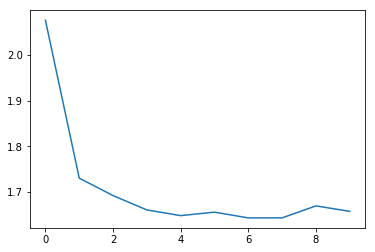

In [39]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

# Evaluating at different "temperatures"

In the `evaluate` function above, every time a prediction is made the outputs are divided by the "temperature" argument passed. Using a higher number makes all actions more equally likely, and thus gives us "more random" outputs. Using a lower value (less than 1) makes high probabilities contribute more. As we turn the temperature towards zero we are choosing only the most likely outputs.

We can see the effects of this by adjusting the `temperature` argument.

In [40]:
print(evaluate('Th', 200, temperature=0.8))

Ther when he is arrest, upon you had question of
 it, and I had room. We had I had prathed
 your the Shot and I unded, Holmes from her it in his ordince hearted it it
 lossing the birreed the house I ro


In [43]:
print(evaluate('Th', 200, temperature=0.5))

That the morning her the mertion of
 the secouse of the down and her hall here from the shour hands was
 not hardled me are me in my heard of the marked which her had course with his heard him of his br


Lower temperatures are less varied, choosing only the more probable outputs:

In [41]:
print(evaluate('Th', 200, temperature=0.2))

Ther in the house which my hands of the proble which he was not her which he had her which her and her which I had been me the shour the man of the face of the more her which he was hard of the misting-


Higher temperatures more varied, choosing less probable outputs:

In [42]:
print(evaluate('Th', 200, temperature=1.4))

Thur, proformanil
 bedrew.

 "York," drowed I, Weden,? I were? WhacI reantumed coflicem you yoursh rine
 cossel-count, window us powpeesss pose
 a bundlank-thablep, drie you?" "Wou dresor laim done-cque


In [44]:
print(evaluate('Th', 200, temperature=1.0))

Then she bore Vave your diagaried of his birlowed it told that I have
 or with it, the bayn wome alous--expresent first of
 frony, cacter carric
 himsed of where you wout mare hope's my shoped trage-com


# Exercises

* Train with your own dataset, e.g.
    * Text from another author
    * Blog posts
    * Code
* Increase number of layers and network size to get better results

**Next**: [Generating Names with a Conditional Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/conditional-char-rnn/conditional-char-rnn.ipynb)